<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/%EC%8A%B9%ED%98%9C/img_preprocessing_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install image_dehazer


In [25]:
# import 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math
import image_dehazer

# contrast 함수 version1,2

In [30]:
# contrast 함수 1
def contrast(img, mask, ksize):
    # # Morphlogy - Tophat

    # ksize = int(img.mean() * 0.5)
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (ksize, ksize))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    # contrast
    low = int(img.mean())*1.3
    high = low + 100
    height, width = img.shape
    
    img = img.astype("float")
    img_ = (255 / (high - low)) * (img-low)
    img_ = ((img_>0)*img_)
    img_ = ((img_-255)>0)*255+img_*(img_<255)
    img_ = img_.astype("uint8")  
    # 마스크 씌우기
    img = cv2.bitwise_and(img_, mask)

    return img


  # alpha = 1.49
  # img = np.clip((1+alpha)*img - 128*alpha, 0, 255).astype(np.uint8)


# contrast 함수 2
def contrast_roi(img, low, high):
    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (img[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    return img_

In [31]:
def guided_Fitler(I, p, r, eps):
    """
    This is a guided filter implementation depends on opencv
    For more info about guided filter, please refer to
    https://en.wikipedia.org/wiki/Guided_filter
    :parms
    I: guided image
    p: filtering input image
    r: window radius
    eps: regularization
    :return
    filtering output q
    """
    ksize = 2 * r + 1
    I = I.astype(np.float32)
    P = p.astype(np.float32)

    mean_i = cv2.blur(I, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)
    mean_p = cv2.blur(P, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)
    corr_i = cv2.blur(I * I, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)
    corr_ip = cv2.blur(I * P, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)

    var_i = corr_i - mean_i * mean_i
    cov_ip = corr_ip - mean_i * mean_p

    a = cov_ip / (var_i + eps)
    b = mean_p - a * mean_i

    a = cv2.blur(a, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)
    b = cv2.blur(b, (ksize, ksize), borderType=cv2.BORDER_REFLECT_101)

    q = a * I + b
    return q.astype(np.uint8)

# merong1 함수 (전처리- 이상함 좀)

In [ ]:
# 이미지 1개 img 적용
img = cv2.imread('1_F.jpg',cv2.IMREAD_COLOR)

mask


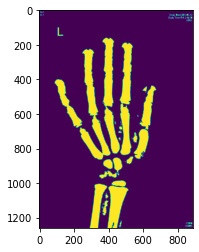

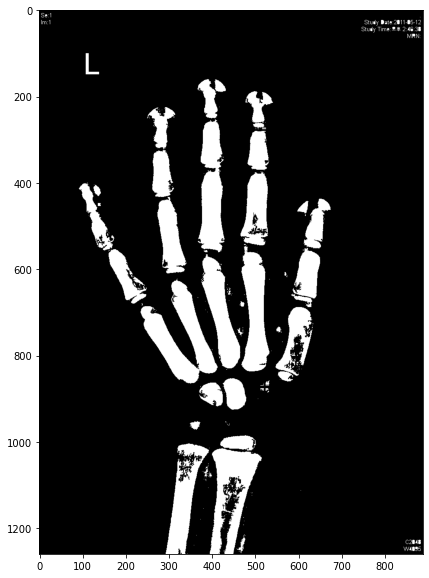

In [ ]:

# 이미지 전처리 함수 (img, 모폴로지값1, 2,3)
def merong(img,a,b,c):
  # 이미지 가져오기
  # img = cv2.imread('1_F_손목 - 복사본.jpg',cv2.IMREAD_COLOR)
  img_ = img.copy()

  # 이미지 Lab
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

  # 모폴리지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
  img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

  # 필터
  img = cv2.bilateralFilter(img,-1, 10, 5)

  # Lab to gray for binary
  img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # # 정규화
  # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

  # # 평탄화 (Clahe)
  # # img = cv2.equalizeHist(img)
  # clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) #CLAHE 생성
  # img= clahe.apply(img)           #CLAHE 적용


  # binary
  ret, mask = cv2.threshold(img, 
                          np.mean(img), # thresh= 이미지의 평균값을 임계치로
                          255,
                          cv2.THRESH_BINARY)
  
  # 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
  contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                         cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                         cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 
  # 그려주기
  cv2.drawContours(mask, contours,
                   -1, (255, 255, 255), -1) # -1: 모든 컨트어 표시 /color/ fill

  print('mask')
  plt.imshow(mask)
  plt.show()

  #### 강 조
  # 모폴로지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (b, b))
  img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

  # contrast
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
  # # 뼈강조하고 마스크랑 비트 연산
  # # 모폴로지
  # k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (c, c))
  # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)

  # contrast 함수 넣어주기 
  img= contrast(img,mask,c)



  # 컨투어
  contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img, contours, -1, (255, 255, 255), -1)

  # 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
  img = cv2.bitwise_and(img, mask) 

  # 크기 표준화
  # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  plt.figure(figsize=(12,10))
  plt.imshow(img,'gray')
  plt.show()

merong(img,55,30,50)


# dehaze

In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('def_file.py','wb').write(src)
import def_file

Saving def_file.py to def_file (1).py


In [14]:
import def_file

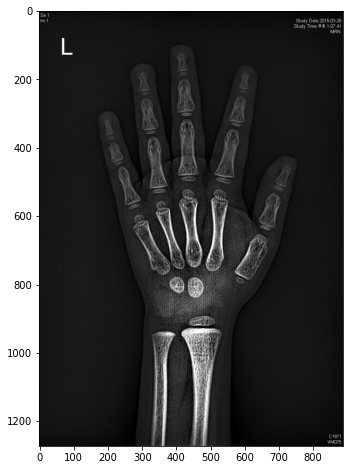

In [90]:
import matplotlib.pyplot as plt

def dehazzz(img):
  if __name__ == '__main__':
      # HazeImg = cv2.imread('8_F.jpg',cv2.IMREAD_COLOR)
      HazeImg= img

      # Resize image
      '''
      Channels = cv2.split(HazeImg)
      rows, cols = Channels[0].shape
      HazeImg = cv2.resize(HazeImg, (int(0.4 * cols), int(0.4 * rows)))
      '''

      # Estimate Airlight
      windowSze = 15
      AirlightMethod = 'fast'
      A = def_file.Airlight(HazeImg, AirlightMethod, windowSze)

      # Calculate Boundary Constraints
      windowSze = 3
      C0 = 20         # Default value = 20 (as recommended in the paper)
      C1 = 300        # Default value = 300 (as recommended in the paper)
      Transmission = def_file.BoundCon(HazeImg, A, C0, C1, windowSze)                  #   Computing the Transmission using equation (7) in the paper

      # Refine estimate of transmission
      regularize_lambda = 1       # Default value = 1 (as recommended in the paper) --> Regularization parameter, the more this  value, the closer to the original patch wise transmission
      sigma = 5
      Transmission = def_file.CalTransmission(HazeImg, Transmission, regularize_lambda, sigma)     # Using contextual information

      # Perform DeHazing
      HazeCorrectedImg = def_file.removeHaze(HazeImg, Transmission, A, 0.85) #0.85

      # plt.imshow(HazeImg)
      # plt.show()
      return HazeCorrectedImg

img_= dehazzz(img)
plt.figure(figsize=(6,8))
plt.imshow(img_)
plt.show()

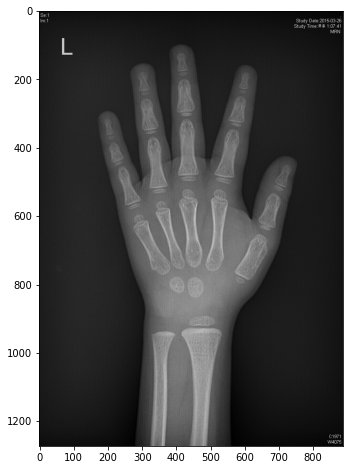

In [83]:
plt.figure(figsize=(6,8))
plt.imshow(img)
plt.show()

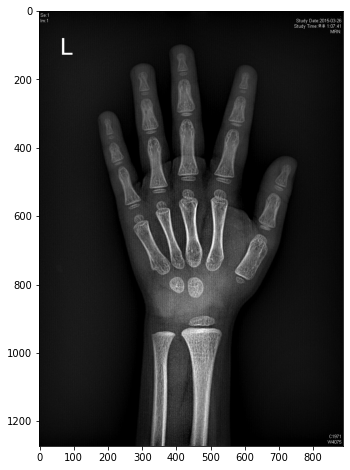

In [92]:
img1 = image_dehazer.remove_haze(img)		# Remove Haze
# img1 = image_dehazer.remove_haze(img)		# Remove Haze
plt.figure(figsize=(6,8))
plt.imshow(img1)
plt.show()

# merong2 함수 (좀 고침)

In [74]:
# 이미지 1개 img 적용
img = cv2.imread('8_F.jpg',cv2.IMREAD_COLOR)

52.672944465692105


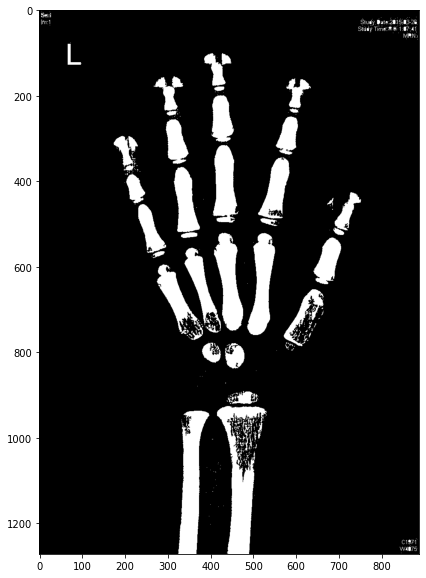

In [93]:
## 메롱두번쨰 
# 이미지 전처리 함수 (img, 모폴로지값1, 2,3)
def merong(img,a,b,d,e):
  # 이미지 가져오기
  # img = cv2.imread('1_F_손목 - 복사본.jpg',cv2.IMREAD_COLOR)
  img1 = img.copy()

  # dehazing (must be a color image)
  # img1 = image_dehazer.remove_haze(img1)		# Remove Haze\
  # img1 = image_dehazer.remove_haze(img1)		# Remove Haze
  img1= dehazzz(img1)

  # 이미지 Lab
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)

  # 모폴리지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
  img1 = cv2.morphologyEx(img1, cv2.MORPH_TOPHAT, k) # 밝기 값이 크게 튀는 곳을 강조

  # 필터
  img1 = cv2.bilateralFilter(img1,-1, d, e)
  # img1= guided_Fitler(img1, img1, r=3, eps=100)

  # Lab to gray for binary
  img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  # 정규화
  img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX)

  # 평탄화 (Clahe)
  img1 = cv2.equalizeHist(img1)
  clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) #CLAHE 생성
  img1= clahe.apply(img1)           #CLAHE 적용


  # binary
  ret, mask = cv2.threshold(img1,
                            np.mean(img1), # thresh= 이미지의 평균값을 임계치로
                            255,
                            cv2.THRESH_BINARY) # ret - 임계값, mask = img마스크
  
  # 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
  contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                         cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                         cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 

  cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


  # plt.imshow(mask)
  # plt.show()










  #### 강 조
  img2 = img.copy()
  print(img2.mean())
  # 모폴로지
  k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
  img2 = cv2.morphologyEx(img2, cv2.MORPH_TOPHAT, k2)

  # contrast
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  # img2= contrast(img2,mask,c)
  # if img2.mean() <= 15:
  #     low = img2.mean() * 2.3
  #     high = img2.mean() * 2.5
  # elif img2.mean() <= 20:
  #     low = img2.mean() * 2.3
  #     high = img2.mean() * 2.8
  # else:
  #     low = img2.mean() * 2.3
  #     high = img2.mean() * 3
  if img2.mean() <= 15:
      low = img2.mean() * 3
      high = img2.mean() * 3.5
  elif img2.mean() <= 20:
      low = img2.mean() * 3
      high = img2.mean() * 3.6
  else:
      low = img2.mean() * 3
      high = img2.mean() * 3.7


  img2 = contrast_roi(img2, low, high)



    
  # # 뼈강조하고 마스크랑 비트 연산
  # # 모폴로지
  # k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (c, c))
  # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)


  # 컨투어
  contours, hierarchy = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img2, contours, -1, (255, 255, 255), -1)

  # 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
  img2 = cv2.bitwise_and(img2, mask) 
  # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

  plt.figure(figsize=(12,10))
  plt.imshow(img2,'gray')
  plt.show()

merong(img,60,55,25,10)


# 함수 이미지path로 적용시켜보기 
- 이렇게까지 했는데도 살이 그대로 남아있는 이유는?

### 1

['8_F.jpg', '9_F.jpg', '6_F.jpg', '7_F.jpg', '5_F.jpg', '1_F.jpg', '4_F.jpg', '20_F.jpg', '16_F.jpg', '19_F.jpg', '17_F.jpg', '15_F.jpg', '12_F.jpg', '3_F.jpg', '13_F.jpg', '14_F.jpg', '11_F.jpg', '18_F.jpg', '2_F.jpg', '10_F.jpg', 'Bone age 3yr F.xlsx', 'BA_F_3yr.zip']
52.672944465692105


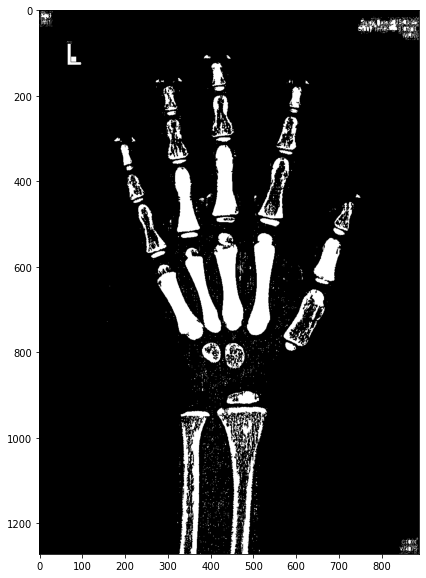

60.38881629531475


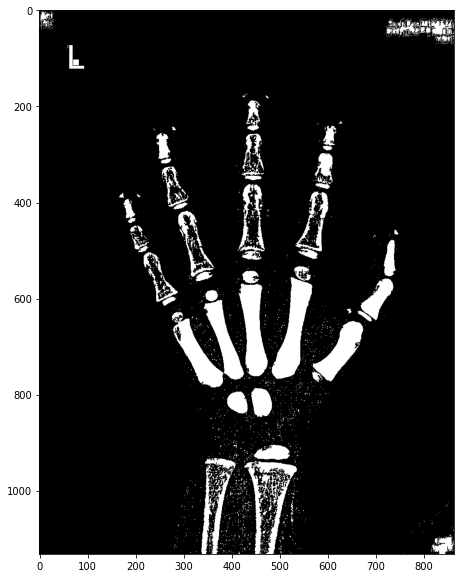

58.64716159611993


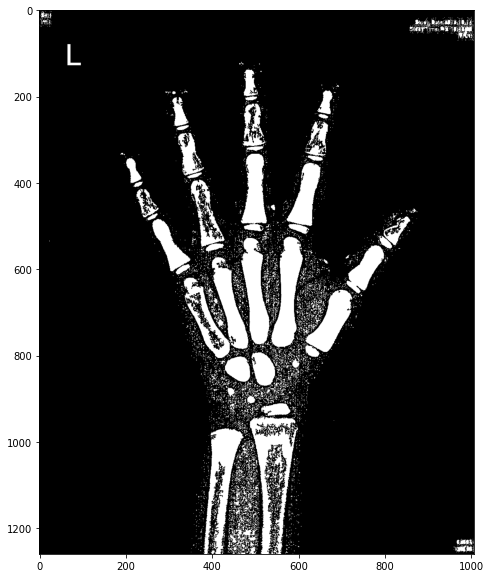

33.437614612957866


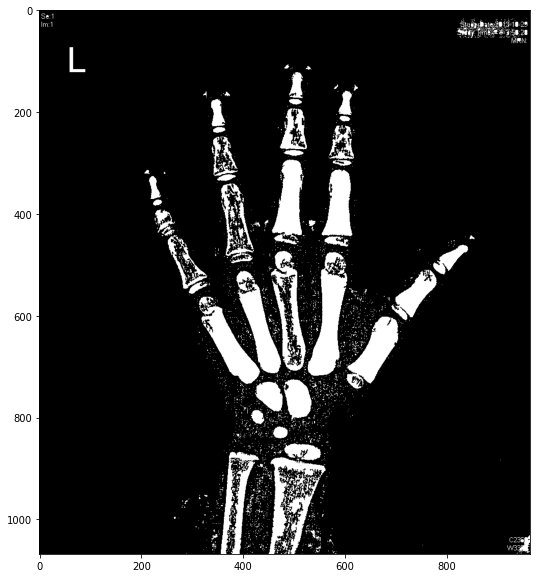

43.00521910687352


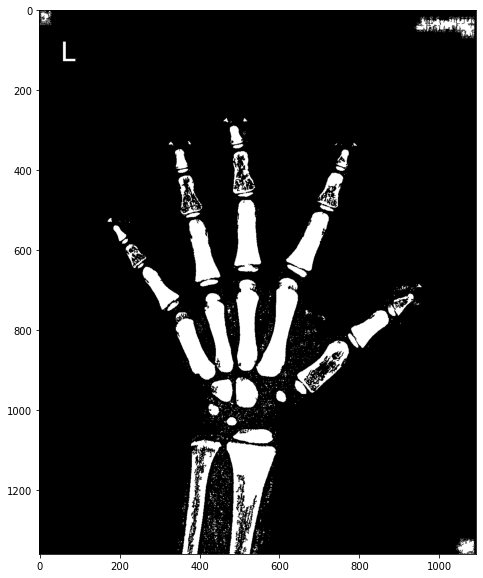

In [45]:
# 이미지 여러개에 함수 적용
import os
path = '/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/first'
dir_list = os.listdir(path)
print(dir_list)

for item in dir_list[:5] :
  img = cv2.imread(path+'/'+f'{item}',cv2.IMREAD_COLOR)
  merong(img,55,25,25,10) # 원래꺼 (스킨은 잘 안빠지고 지골이 잘 빠짐)
  # merong(img,55,60,50,25)  # 새로운거 (지골이 잘 안빠지고 스킨이 잘 빠짐)

### 2

['8_F.jpg', '9_F.jpg', '6_F.jpg', '7_F.jpg', '5_F.jpg', '1_F.jpg', '4_F.jpg', '20_F.jpg', '16_F.jpg', '19_F.jpg', '17_F.jpg', '15_F.jpg', '12_F.jpg', '3_F.jpg', '13_F.jpg', '14_F.jpg', '11_F.jpg', '18_F.jpg', '2_F.jpg', '10_F.jpg', 'Bone age 3yr F.xlsx', 'BA_F_3yr.zip']
52.672944465692105


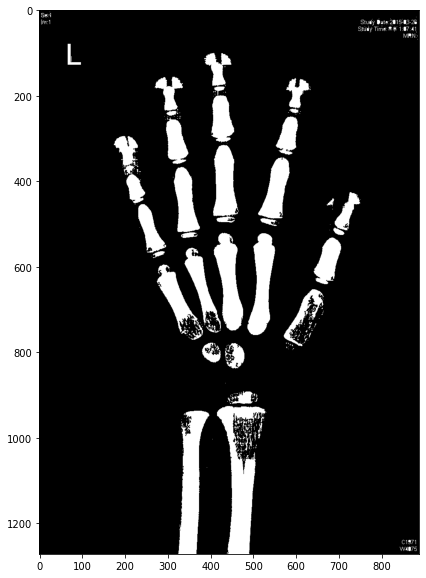

60.38881629531475


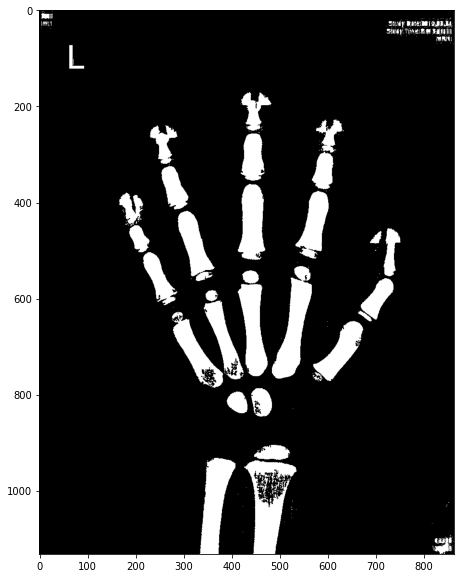

58.64716159611993


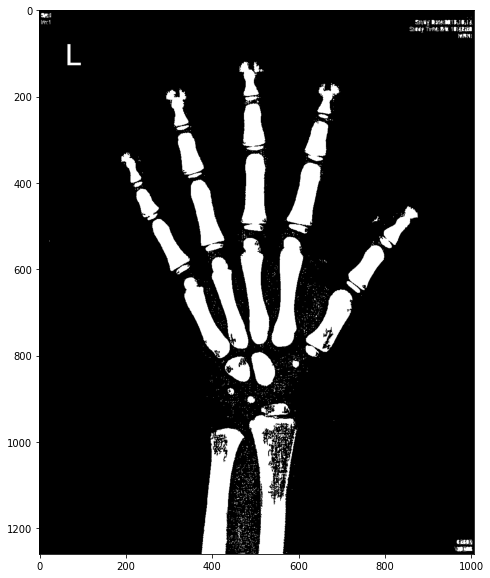

33.437614612957866


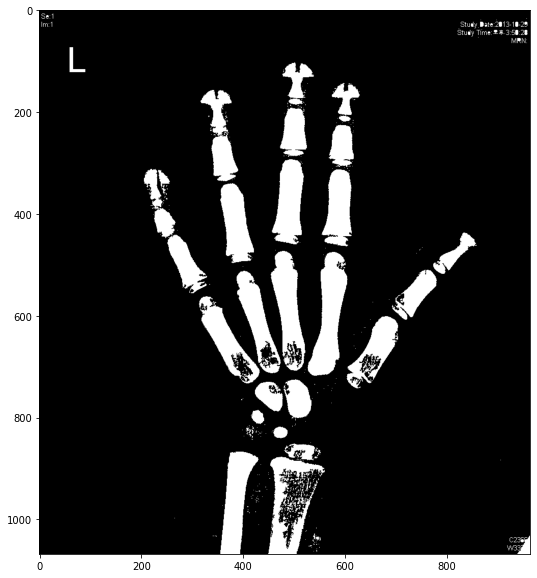

43.00521910687352


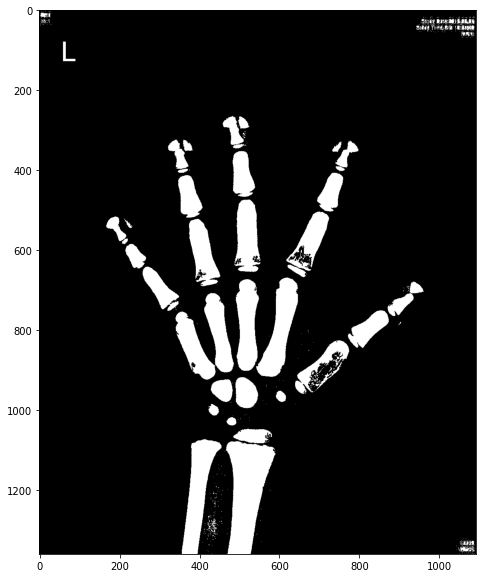

In [44]:
# 이미지 여러개에 함수 적용
import os
path = '/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/first'
dir_list = os.listdir(path)
print(dir_list)

for item in dir_list[:5] :
  img = cv2.imread(path+'/'+f'{item}',cv2.IMREAD_COLOR)
  # merong(img,55,25,25,10) # 원래꺼 (스킨은 잘 안빠지고 지골이 잘 빠짐)
  merong(img,55,60,25,10)  # 새로운거 (지골이 잘 안빠지고 스킨이 잘 빠짐)

### 3

['8_F.jpg', '9_F.jpg', '6_F.jpg', '7_F.jpg', '5_F.jpg', '1_F.jpg', '4_F.jpg', '20_F.jpg', '16_F.jpg', '19_F.jpg', '17_F.jpg', '15_F.jpg', '12_F.jpg', '3_F.jpg', '13_F.jpg', '14_F.jpg', '11_F.jpg', '18_F.jpg', '2_F.jpg', '10_F.jpg', 'Bone age 3yr F.xlsx', 'BA_F_3yr.zip']
52.672944465692105


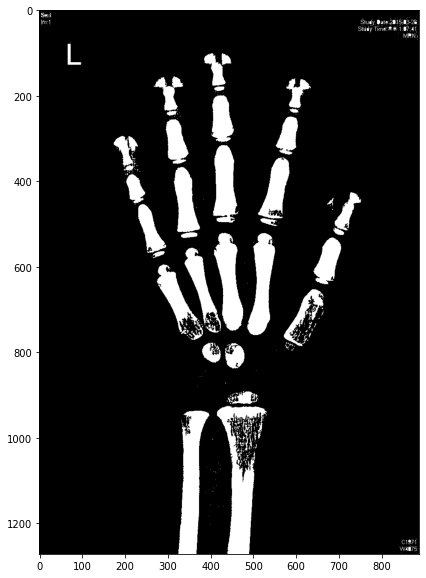

60.38881629531475


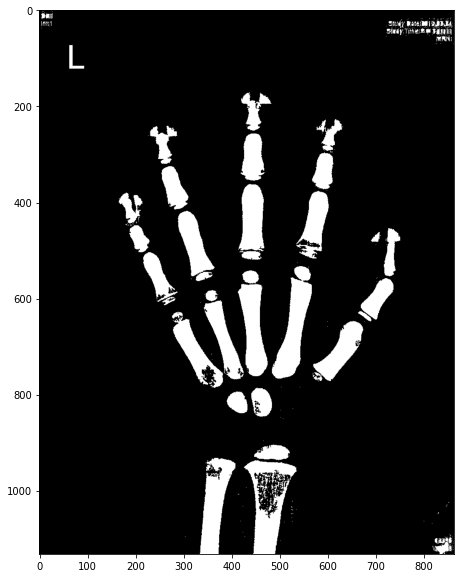

58.64716159611993


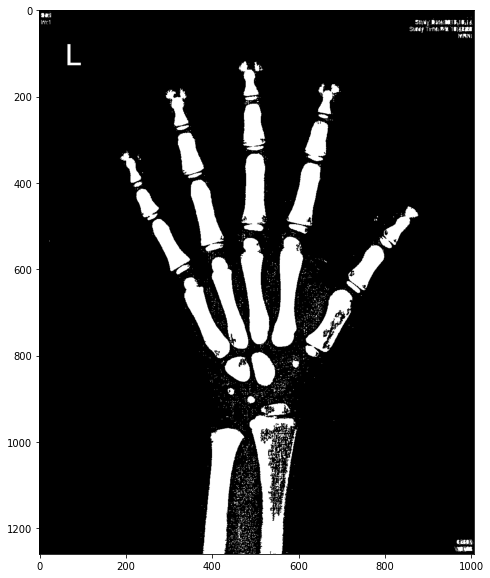

33.437614612957866


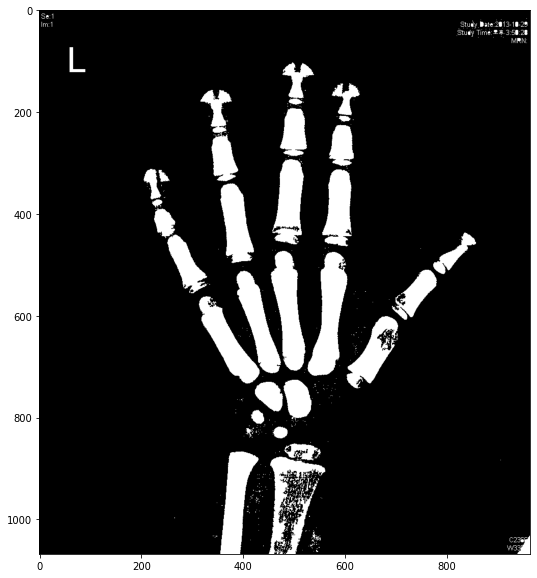

43.00521910687352


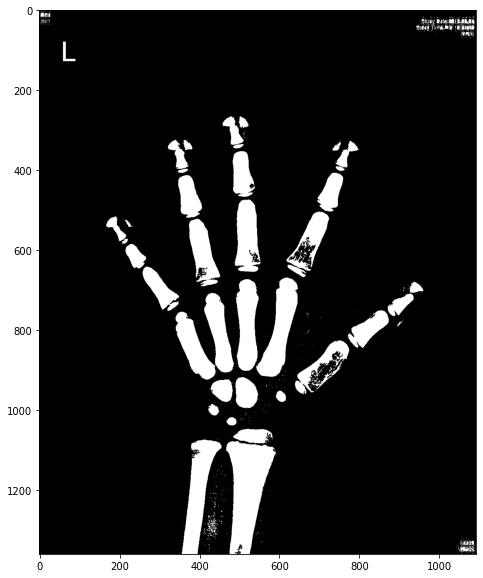

In [71]:
# 이미지 여러개에 함수 적용
import os
path = '/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/first'
dir_list = os.listdir(path)
print(dir_list)

for item in dir_list[:5] :
  img = cv2.imread(path+'/'+f'{item}',cv2.IMREAD_COLOR)
  # merong(img,55,25,25,10) # 원래꺼 (스킨은 잘 안빠지고 지골이 잘 빠짐)
  # merong(img,55,60,25,10)  # 새로운거 (지골이 잘 안빠지고 스킨이 잘 빠짐)
  merong(img,60,55,25,10)


In [16]:
# 이미지 1개 가져오기
from google.colab import files
uploaded = files.upload()

Saving 6_F.jpg to 6_F (4).jpg


In [6]:
# 이미지 1개 img 적용
img = cv2.imread('1_F.jpg',cv2.IMREAD_COLOR)


# 비밀

In [72]:
# import sys
# import numpy as np
# import cv2
# import math

# def EditFcnProto(templateFile, height, width):
# 	with open(templateFile, 'r') as ft:
# 		template = ft.read()
# 		outFile = 'DehazeNetFcn.prototxt'
# 		with open(outFile, 'w') as fd:
# 			fd.write(template.format(height_15=height+15, width_15=width+15,
# 				height_11=height+11, width_11=width+11))

# def TransmissionEstimate(im_path, height, width):
# 	caffe.set_mode_cpu()
# 	net = caffe.Net('DehazeNet.prototxt', 'DehazeNet.caffemodel', caffe.TEST)
# 	net_full_conv = caffe.Net('DehazeNetFcn.prototxt', 'DehazeNet.caffemodel', caffe.TEST)
# 	net_full_conv.params['ip1-conv'][0].data.flat = net.params['ip1'][0].data.flat
# 	net_full_conv.params['ip1-conv'][1].data[...] = net.params['ip1'][1].data
# 	im = caffe.io.load_image(im_path)
# 	npad = ((7,8), (7,8), (0,0))
# 	im = np.pad(im, npad, 'symmetric')
# 	transformers = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
# 	transformers.set_transpose('data', (2,0,1))
# 	transformers.set_channel_swap('data', (2,1,0))
# 	out = net_full_conv.forward_all(data=np.array([transformers.preprocess('data', im-0.2)]))
# 	transmission = np.reshape(out['ip1-conv'], (height,width))
# 	return transmission

# def DarkChannel(im,sz):
# 	b,g,r = cv2.split(im)
# 	dc = cv2.min(cv2.min(r,g),b)
# 	kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
# 	dark = cv2.erode(dc,kernel)
# 	return dark

# def AtmLight(im,dark):
# 	[h,w] = im.shape[:2]
# 	imsz = h*w
# 	numpx = int(max(math.floor(imsz/1000),1))
# 	darkvec = dark.reshape(imsz,1)
# 	imvec = im.reshape(imsz,3)
# 	indices = darkvec.argsort()
# 	indices = indices[imsz-numpx::]
# 	atmsum = np.zeros([1,3])
# 	for ind in range(1,numpx):
# 		atmsum = atmsum + imvec[indices[ind]]
# 	A = atmsum / numpx
# 	return A

# def Guidedfilter(im,p,r,eps):
# 	mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
# 	mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
# 	mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
# 	cov_Ip = mean_Ip - mean_I*mean_p
# 	mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
# 	var_I   = mean_II - mean_I*mean_I
# 	a = cov_Ip/(var_I + eps)
# 	b = mean_p - a*mean_I
# 	mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
# 	mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))
# 	q = mean_a*im + mean_b
# 	return q

# def TransmissionRefine(im,et):
# 	gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# 	gray = np.float64(gray)/255
# 	r = 60
# 	eps = 0.0001
# 	t = Guidedfilter(gray,et,r,eps)
# 	return t

# def Recover(im,t,A,tx = 0.1):
# 	res = np.empty(im.shape,im.dtype)
# 	t = cv2.max(t,tx)
# 	for ind in range(0,3):
# 		res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
# 	return res

# if __name__ == '__main__':
# 	if not len(sys.argv) == 2:
# 		print 'Usage: python DeHazeNet.py haze_img_path'
# 		exit()
# 	else:
# 		im_path = sys.argv[1]
# 	src = cv2.imread('6_F.jpg')
# 	height = src.shape[0]
# 	width = src.shape[1]
# 	templateFile = 'DehazeFcnTemplate.prototxt'
# 	EditFcnProto(templateFile, height, width)
# 	I = src/255.0
# 	dark = DarkChannel(I,15)
# 	A = AtmLight(I,dark)
# 	te = TransmissionEstimate(im_path, height, width)
# 	t = TransmissionRefine(src,te)
# 	J = Recover(I,t,A,0.1)
# 	plt.imshow('TransmissionEstimate',te)
# 	plt.imshow('TransmissionRefine',t)
# 	plt.imshow('Origin',src)
# 	plt.imshow('Dehaze',J)
 
#   plt.show()
 

In [ ]:
# dehazing
# def DarkChannel(im,sz):
#     b,g,r = cv2.split(im)
#     dc = cv2.min(cv2.min(r,g),b);
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
#     dark = cv2.erode(dc,kernel)
#     return dark

# def AtmLight(im,dark):
#     [h,w] = im.shape[:2]
#     imsz = h*w
#     numpx = int(max(math.floor(imsz/1000),1))
#     darkvec = dark.reshape(imsz);
#     imvec = im.reshape(imsz,3);

#     indices = darkvec.argsort();
#     indices = indices[imsz-numpx::]

#     atmsum = np.zeros([1,3])
#     for ind in range(1,numpx):
#        atmsum = atmsum + imvec[indices[ind]]

#     A = atmsum / numpx;
#     return A

# def TransmissionEstimate(im,A,sz):
#     omega = 0.95;
#     im3 = np.empty(im.shape,im.dtype);

#     for ind in range(0,3):
#         im3[:,:,ind] = im[:,:,ind]/A[0,ind]

#     transmission = 1 - omega*DarkChannel(im3,sz);
#     return transmission

# def Guidedfilter(im,p,r,eps):
#     mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
#     mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
#     mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
#     cov_Ip = mean_Ip - mean_I*mean_p;

#     mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
#     var_I   = mean_II - mean_I*mean_I;

#     a = cov_Ip/(var_I + eps);
#     b = mean_p - a*mean_I;

#     mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
#     mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

#     q = mean_a*im + mean_b;
#     return q;

# def TransmissionRefine(im,et):
#     gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
#     gray = np.float64(gray)/255;
#     r = 60;
#     eps = 0.0001;
#     t = Guidedfilter(gray,et,r,eps);

#     return t;

# def Recover(im,t,A,tx = 0.1):
#     res = np.empty(im.shape,im.dtype);
#     t = cv2.max(t,tx);

#     for ind in range(0,3):
#         res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

#     return res

# if __name__ == '__main__':
#     import sys
#     try:
#         fn = sys.argv[1]
#     except:
#         fn = '6_F.jpg'

#     def nothing(*argv):
#         pass

#     src = cv2.imread(fn)

#     I = src.astype('float64')/255;
 
#     dark = DarkChannel(I,15);
#     A = AtmLight(I,dark);
#     te = TransmissionEstimate(I,A,15);
#     t = TransmissionRefine(src,te);
#     J = Recover(I,t,A,0.1);

#     plt.imshow("dark",dark);
#     plt.imshow("t",t);
#     plt.imshow('I',src);
#     plt.imshow('J',J);

#     plt.show()

In [10]:
# """Single image dehazing."""
# from __future__ import division
# import cv2
# import numpy as np


# class Channel_value:
#     val = -1.0
#     intensity = -1.0


# def atmospheric_light(img, gray):
#     top = int(img.shape[0] * img.shape[1] * 0.001)
#     print(img.shape[0],img.shape[0])
#     toplist = [Channel_value()] * top
#     dark_channel = darkchannel(img)
#     print(dark_channel)
#     for y in range(img.shape[0]):
#         for x in range(img.shape[1]):
#             # Accessing the rgb values separately
#             val = img.item(y, x, dark_channel)
#             # Calculating the intensity in the gray scale image so it is easy to find the lightest one
#             intensity = gray.item(y, x)
#             # This finds the highest intensity of the dark channel pixels
#             for t in toplist:
#                 if t.val < val or (t.val == val and t.intensity < intensity):
#                     t.val = val
#                     t.intensity = intensity
#                     break
#     # This is compared with the pixels in the dark channel and max one is taken as atmospheric light
#     max_channel = Channel_value()
#     for t in toplist:
#         if t.intensity > max_channel.intensity:
#             max_channel = t
#     #Thus we calculate A which is used in calculation of dehazing   
#     return max_channel.intensity


# def darkchannel(img):
#     # This is the lightest of the three channels R,G,B to give the pixel with least intensity . This is generally around 0.
#     return np.unravel_index(np.argmin(img), img.shape)[2]


# def clamp(minimum, x, maximum):
#     return max(minimum, min(x, maximum))


# def dehaze(img, light_intensity, windowSize, t0, w ,roh):
#     # Calculating the size of image
#     size = (img.shape[0], img.shape[1])
#     # Designing layout of the output image
#     outputimg = np.zeros(img.shape, img.dtype)
#     # calculating transmission map
#     for y in range(size[0]):
#         for x in range(size[1]):
#             x_low = max(x-(windowSize//2), 0)
#             y_low = max(y-(windowSize//2), 0)
#             x_high = min(x+(windowSize//2), size[1])
#             y_high = min(y+(windowSize//2), size[0])
#             sliceimg = img[y_low:y_high, x_low:x_high]
#             #using the sliding windows  to calculate the corner vertices
#             dark_channel = darkchannel(sliceimg)
#             #This is the transmission value. w will be the weight and roh added will be to avoid unnatural haze
#             t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity) + roh
#             # Each R,G,B channel needs to be modified
#             outputimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
#             outputimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
#             outputimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
#     return outputimg


# # def main():
# #     imageName = input()  # eg. fg5.jpg
# #     img = cv2.imread(imageName)
# #     cv2.namedWindow("Dehazed image")
# #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #     light_intensity = atmospheric_light(img, gray)
# #     w = 0.95
# #     t0 = 0.50
# #     roh = 0.012
# #     outimg = dehaze(img, light_intensity, 20, t0, w , roh)
# #     plt.imshow(outimg)
# #     plt.show()




# def dehaze(img, light_intensity, windowSize, t0, w ,roh):
#     # Calculating the size of image
#     size = (img.shape[0], img.shape[1])
#     # Designing layout of the output image
#     outputimg = np.zeros(img.shape, img.dtype)
#     # calculating transmission map
#     for y in range(size[0]):
#         for x in range(size[1]):
#             x_low = max(x-(windowSize//2), 0)
#             y_low = max(y-(windowSize//2), 0)
#             x_high = min(x+(windowSize//2), size[1])
#             y_high = min(y+(windowSize//2), size[0])
#             sliceimg = img[y_low:y_high, x_low:x_high]
#             #using the sliding windows  to calculate the corner vertices
#             dark_channel = darkchannel(sliceimg)
#             #This is the transmission value. w will be the weight and roh added will be to avoid unnatural haze
#             t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity) + roh
#             # Each R,G,B channel needs to be modified
#             outputimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
#             outputimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
#             outputimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
#     return outputimg


# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# light_intensity = atmospheric_light(img, gray)
# dehaze(img, light_intensity, 20, t0, w , roh)